In [1]:
import pandas as pd
import json
import numpy as np
import re
from nltk.stem.porter import *
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn import model_selection,metrics,naive_bayes,preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import warnings
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
stemmer = PorterStemmer()
warnings.filterwarnings('ignore')
mypca = PCA(0.95)
lda = LinearDiscriminantAnalysis(n_components=1)

C:\Users\Almalis\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def clean_data(X):
    STOPWORDS = set(stopwords.words('english'))
    X=X.str.lower()
    X=X.str.replace("[/(){}\[\]\|@,;]", " ")
    X=X.str.replace("[^0-9a-z #+_]", " ")
    X = X.str.replace(r'\d+','')
    X = X.apply(lambda x: ' '.join([w for w in str(x).split() if (len(w)>2 and w not in STOPWORDS) ] ))
    X = X.apply(lambda x: x.split()) 
    return X

def target_arrange(y):
    
    for i in range(len(y)):
        if y.values[i]=="Neutral":
            y.values[i]=0.0
        else:
            y.values[i]=1.0
            
    y=y.to_numpy()  
    y=y.reshape(y.shape[0],1)
    y= pd.DataFrame(data=y)
    y=np.ravel(y)
    y=y.astype('float')
    return y

def select_n_components(ratio, goal):
        # Set initial variance explained so far
        s=0.0 
        # Set initial number of features
        num_components = 0

        for i in ratio:
            s += i
            num_components += 1
            if s >= goal:
                break

        # Return the number of components
        return num_components

In [4]:
with open("All_Tickers.json","r") as fp:
#with open("General_Market.json",encoding='utf8') as fp:
    json_d = json.load(fp)
 
ticks_d = json_d['data']
df = pd.DataFrame(ticks_d)

X= pd.DataFrame(columns=['Date', 'Article','Target'])
X['Date']=pd.to_datetime(df['date'])
X['Article']=df['title']+" "+df['text']
X['Target']=df['sentiment']

X=X.sort_values("Date")
print("Number of Examples : ",len(X))
X.drop_duplicates(inplace=True)
X.index = range(len(X))
print("Number of Examples after removing duplicates: ",len(X),"\n")
X.to_csv (r'General.csv', index = False, header=True)

print('Number of words before cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
X['Article']=clean_data(X['Article'])
print('Number of words after cleaning : ',X['Article'].apply(lambda x: len(str(x).split(' '))).sum())
print("\n")

y=target_arrange(X['Target'])

print("Neutral Examples : ",(y==0.0).sum())
print("Not Neutral Examples : ",(y==1.0).sum())

Number of Examples :  34125
Number of Examples after removing duplicates:  33921 

Number of words before cleaning :  1305539
Number of words after cleaning :  878498


Neutral Examples :  18194
Not Neutral Examples :  15727


In [5]:
X['Article']= X['Article'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
for i in range(len(X['Article'])): #φέρνω τα tokens ξανά μαζί διαχωριζόμενα με κενά
    X['Article'][i] = ' '.join(X['Article'][i])

print(X['Article'])

0        krato present canaccord virtual growth confer ...
1        pyxi tanker announc date releas second quarter...
2        intellig system announc new board member norcr...
3        vianet group inc announc unaudit second quarte...
4        rewalk robot report second quarter financi res...
                               ...                        
33916    borg warner investig initi former louisiana at...
33917    bayer hour deadlin alert former louisiana atto...
33918    cantor fitzgerald bgc partner chariti day virt...
33919    chariti day virtual unstopp bgc partner cantor...
33920    halo lab provid oregon busi updat toronto busi...
Name: Article, Length: 33921, dtype: object


In [6]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9,min_df=5)
Xv = tfidf_vectorizer.fit_transform(X['Article'])
Xv = pd.DataFrame(Xv.todense())
X_train,X_test,y_train,y_test = train_test_split(Xv,y, test_size=0.3,stratify=y)

ros = RandomOverSampler(sampling_strategy=0.9)
X_train,y_train = ros.fit_resample(X_train, y_train)

print("Neutral Examples in Training set: ",(y_train==0.0).sum())
print("Not Neutral Examples in Training set: ",(y_train==1.0).sum())

#PCA and LDA for SVM

scaler = MinMaxScaler()
X_train1 = scaler.fit_transform(X_train)
X_test1 = scaler.transform(X_test)

X_train_pca = mypca.fit_transform(X_train1)
X_test_pca = mypca.transform(X_test1)

X_train_pca = lda.fit_transform(X_train_pca, y_train)
X_test_pca  = lda.transform(X_test_pca)


Neutral Examples in Training set:  12735
Not Neutral Examples in Training set:  11461


## Naive Bayes


Metrics

 Recall metric: 0.835722047144613
 F1 metric: 0.8313842193135619
 Precision metric: 0.8355987298440918
 Accuracy metric: 0.8313844944482657
 Balanced Accuracy metric: 0.835722047144613 

**************************************************

Normalized confusion matrix
[[0.78 0.22]
 [0.1  0.9 ]]


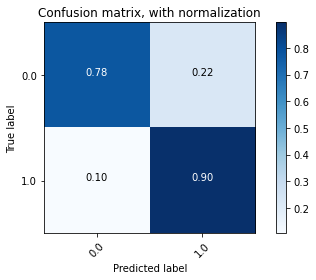

In [7]:
alpha = 0.1 # This is the smoothing parameter for Laplace/Lidstone smoothing
model = naive_bayes.MultinomialNB(alpha=alpha)

model.fit(X_train,y_train)
y_predicted = model.predict(X_test)

print("\nMetrics\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0.0, 1.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0],
                      title='Confusion matrix, with normalization')


## Random Forest 


Metrics

 Recall metric: 0.8659078571067484
 F1 metric: 0.8606550668535751
 Precision metric: 0.8669866646417327
 Accuracy metric: 0.8606662081163408
 Balanced Accuracy metric: 0.8659078571067484 

**************************************************

Normalized confusion matrix
[[0.79 0.21]
 [0.06 0.94]]


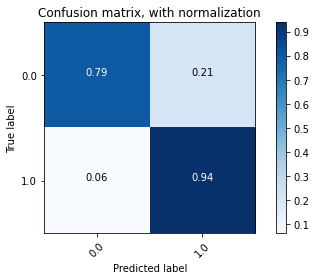

In [8]:
model2 = RandomForestClassifier(n_estimators=100, max_features="auto", n_jobs=-1,class_weight='balanced')
model2.fit(X_train,y_train)
y_predicted = model2.predict(X_test)

print("\nMetrics\n")
recall = metrics.recall_score(y_test,y_predicted,average='macro')
precision = metrics.precision_score(y_test,y_predicted,average='macro')
f1 = metrics.f1_score(y_test,y_predicted,average='macro')
Accur=metrics.accuracy_score(y_test,y_predicted)
B_Accur=metrics.balanced_accuracy_score(y_test,y_predicted)

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, y_predicted,labels=[0.0, 1.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0],
                      title='Confusion matrix, with normalization')

## SVM

{'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}

Metrics

 Recall metric: 0.8461214513587395
 F1 metric: 0.8444637961711439
 Precision metric: 0.8443418225546679
 Accuracy metric: 0.8447479610887295
 Balanced Accuracy metric: 0.8461214513587395 

**************************************************

Normalized confusion matrix
[[0.83 0.17]
 [0.14 0.86]]


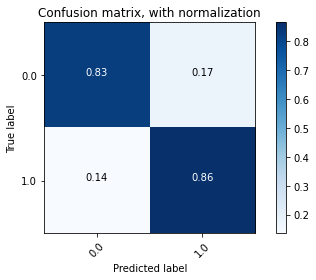

In [9]:
tuned_parameters = [
  
  {'C': [0.005, 0.01, 0.03, 0.1, 1, 10, 100 ], 'gamma': [5, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], 'kernel': ['rbf']}
  
 ]

grid = GridSearchCV(SVC(class_weight='balanced', decision_function_shape='ovr'), tuned_parameters, n_jobs=-1, refit = True, cv=5) 
grid.fit(X_train_pca, y_train) 
print(grid.best_params_) 
grid_predictions = grid.predict(X_test_pca) 

print("\nMetrics\n")
recall = metrics.recall_score(y_test,grid_predictions ,average='macro')
precision = metrics.precision_score(y_test,grid_predictions ,average='macro')
f1 = metrics.f1_score(y_test,grid_predictions ,average='macro')
Accur=metrics.accuracy_score(y_test,grid_predictions )
B_Accur=metrics.balanced_accuracy_score(y_test,grid_predictions )

print(' Recall metric:',recall)
print(' F1 metric:',f1)
print(' Precision metric:',precision)
print(' Accuracy metric:',Accur)
print(' Balanced Accuracy metric:',B_Accur,"\n")
print("**************************************************\n")

cnf_matrix = confusion_matrix(y_test, grid_predictions ,labels=[0.0, 1.0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0.0, 1.0],
                      title='Confusion matrix, with normalization')